In [1]:
from utils import path_setup
path_setup()
import pandas as pd
import os
from src.paths import PROCESSED_DATA, MODELS
import numpy as np
import tensorflow as t
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, LeaveOneOut, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from src.modeling.save_model import save_model
from tensorflow.keras.models import save_model as keras_save_model

In [2]:
filepath=os.path.join(PROCESSED_DATA, "prepaired_data.csv")
df = pd.read_csv(filepath, index_col=0)
df.describe()

,Layer,Amp,FreQ,e,h,Optimal
count,66.000000,66.000000,66.000000,49.000000,49.000000,66.000000
mean,6.272727,4.937879,1.746970,11.073469,1.659184,0.439394
std,1.957592,0.913281,0.244458,2.185442,0.565287,0.500117
min,4.000000,2.500000,1.000000,5.400000,0.400000,0.000000
25%,5.000000,4.500000,1.600000,10.400000,1.300000,0.000000
50%,6.000000,5.000000,1.800000,11.800000,1.600000,0.000000
75%,7.750000,5.500000,1.800000,12.800000,2.000000,1.000000
max,12.000000,6.500000,2.300000,14.100000,3.600000,1.000000


In [3]:
from sklearn.model_selection import train_test_split, LeaveOneOut, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# Подготовка
# Названия признаков
y=df["Optimal"]
X=df[['Amp','FreQ','Layer']]

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, 
                                                    train_size=0.8, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

categories = np.sort(df.Layer.unique())


preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), ["Amp","FreQ"]),      # Стандартизируем Amp и FreQ
       ('encoder', OrdinalEncoder(categories=[categories], handle_unknown='use_encoded_value',unknown_value=-1),["Layer"])   # Layer кодируем
    ]
)

# Определение кол-ва признаков после препроцессинга
preprocessor.fit(X)
X_transformed= preprocessor.transform(X)
input_dim = X_transformed.shape[1]

input_dim


3

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf

def build_model(input_dim, neurons1=8,neurons2=8,dropout=0.3,learning_rate=0.0005):
    tf.random.set_seed(1)
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(neurons1, activation='relu'), # Один скрытый слой 
        Dropout(dropout),
        Dense(neurons2, activation='relu'), # Один скрытый слой 
        Dropout(dropout),
        Dense(1, activation='sigmoid') # Выходной слой 
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [5]:
from scikeras.wrappers import KerasClassifier
early_stop= EarlyStopping(
    monitor='val_loss',  # следим за ошибкой на валидации
    patience=10,         # ждём эпохи без улучшения
    restore_best_weights=True  # возвращаемся к лучшим весам
)
clf = KerasClassifier(
    model=build_model,
    input_dim=input_dim, 
    epochs=400,
    callbacks=[early_stop],
    validation_split=0.2,
    verbose=0,
    random_state=13,
    batch_size=6
)

In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', clf)
])

#Подбор гиперпараметров
param_grid = {
    #'clf__batch_size': [2,4,8,16],
    #'clf__model__neurons1': [4,8,16],
    #'clf__model__neurons2': [4,8,16],
    'clf__model__dropout':[0.3],
    #'clf__model__learning_rate': [0.1, 0.001, 0.0005]
}


grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=LeaveOneOut(),
    scoring='accuracy',
    n_jobs=-1
)


grid.fit(X_trainval, y_trainval)



In [7]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("Best CV accuracy:", grid.best_score_)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Best Params:", grid.best_params_)

Best CV accuracy: 0.8076923076923077
Test accuracy: 0.7857142857142857
Best Params: {'clf__model__dropout': 0.3}


2025-07-10 09:53:47.650498: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-07-10 09:53:47.650883: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

In [ ]:
print(grid.cv_results_['mean_test_score'])
print(grid.cv_results_['std_test_score'])

              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.80      0.67      0.73         6

    accuracy                           0.79        14
   macro avg       0.79      0.77      0.78        14
weighted avg       0.79      0.79      0.78        14



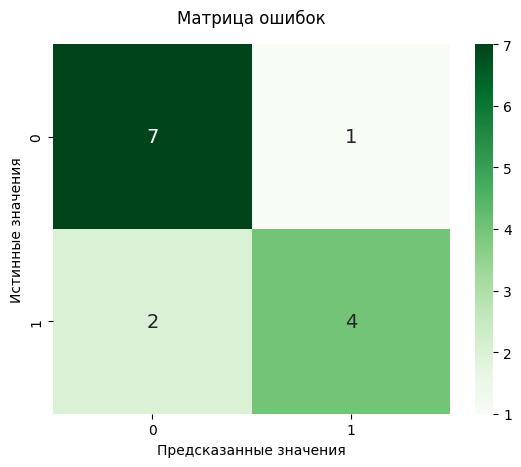

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

cm=confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', annot_kws={'fontsize': 14})
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок', pad=15)
plt.show()

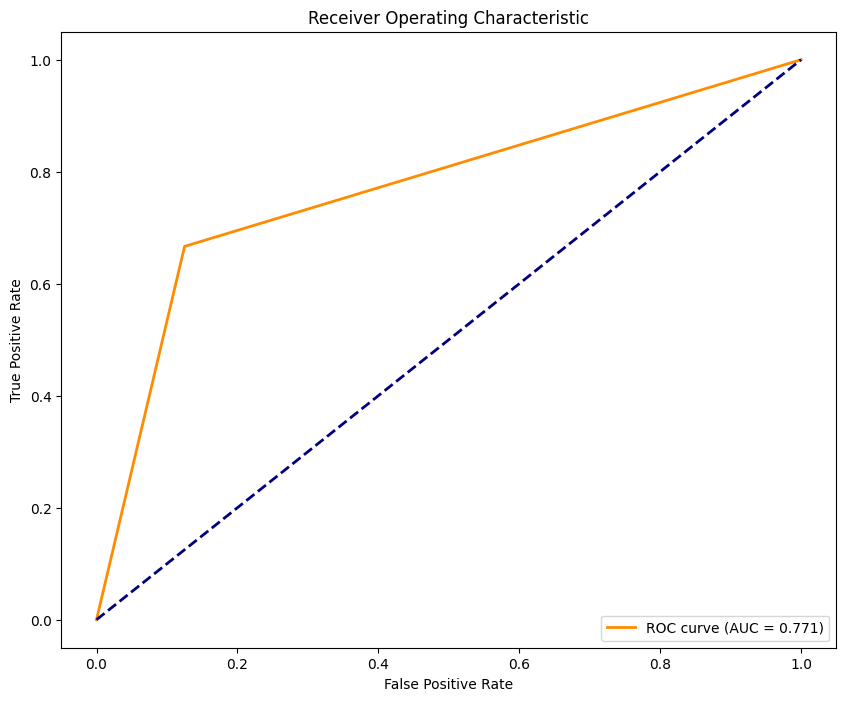

ROC AUC score: 0.771


In [9]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
# Рассчитываем точки ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Вычисляем площадь под кривой
roc_auc = auc(fpr, tpr)

# Визуализируем результат
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#plt.xlim([0\.0, 1.0])
#plt.ylim([0\.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Можно также напрямую вычислить AUC
print(f"ROC AUC score: {roc_auc_score(y_test, y_pred):.3f}")



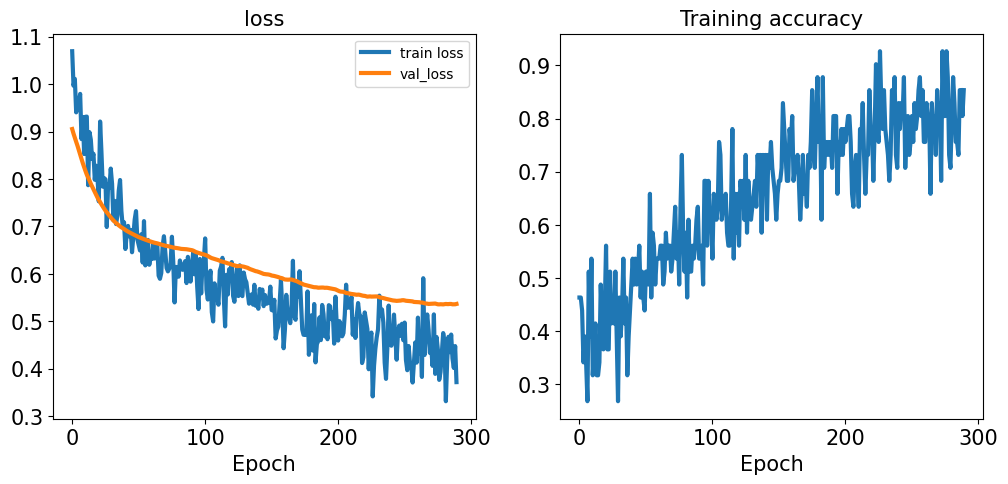

In [10]:
import matplotlib.pyplot as plt
history = grid.best_estimator_.named_steps['clf'].history_
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history['loss'], lw=3, label="train loss")
ax.plot(history["val_loss"], lw=3, label="val_loss")
ax.set_title('loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(history['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [11]:
from src.modeling.save_model import save_model
from tensorflow.keras.models import save_model as keras_save_model

save_model(pipeline.named_steps['preprocess'],'nn_preprocessor.pkl')

neural_clf=grid.best_estimator_.named_steps['clf'].model_
nn_path=os.path.join(MODELS,'nn_clf.keras')
neural_clf.save(nn_path)

*Модели классификации*


*Модели классификации*


In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Random forest
pipeline_rf = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    #"model__n_estimators":np.arange(1,26,2),
    "model__max_depth": np.arange(1,100,2)
}



grid_rf = GridSearchCV(
    pipeline_rf,
    param_grid=param_grid_rf,
    cv=LeaveOneOut(),
    scoring="accuracy",
    n_jobs=-1
)


grid_rf.fit(X_trainval, y_trainval)

best_model_rf = grid_rf.best_estimator_

print("RF Best CV accuracy:", grid_rf.best_score_)
print("RandomForest Test accuracy:", accuracy_score(y_test, best_model_rf.predict(X_test)))
print("Best Params RF:", grid_rf.best_params_)


In [ ]:
cm_rf=confusion_matrix(y_test, best_model_rf.predict(X_test))
print(classification_report(y_test,best_model_rf.predict(X_test)))

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', annot_kws={'fontsize': 14})
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок', pad=15)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

rf = grid_rf.best_estimator_.named_steps["model"]
feature_names = grid_rf.best_estimator_.named_steps["preprocess"].get_feature_names_out()
importances = rf.feature_importances_

# Важность признаков
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# График
plt.figure(figsize=(10, 5))
feat_imp.plot(kind="bar")
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

#Random forest
pipe_logreg = Pipeline([
    ('preprocess', preprocessor),
    ('model', LogisticRegression(
        penalty="l2",
        solver= "liblinear",
        class_weight="balanced",
        random_state=13))
])

param_grid_logreg = {
    "model__max_iter": np.arange(100,1001,100)
}



grid_logreg = GridSearchCV(
    pipe_logreg,
    param_grid=param_grid_logreg,
    cv=LeaveOneOut(),
    scoring="accuracy",
    n_jobs=-1
)


grid_logreg.fit(X_trainval, y_trainval)

best_model_logreg = grid_logreg.best_estimator_

print("LogReg Best CV accuracy:", grid_logreg.best_score_)
print("LogReg Test accuracy:", accuracy_score(y_test, best_model_logreg.predict(X_test)))
print("Best Params LogReg:", grid_logreg.best_params_)

In [ ]:
cm_rf=confusion_matrix(y_test, best_model_logreg.predict(X_test))
print(classification_report(y_test,best_model_logreg.predict(X_test)))

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', annot_kws={'fontsize': 14})
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок', pad=15)
plt.show()

from src.modeling.save_model import save_model
from tensorflow.keras.models import save_model as keras_save_model

save_model(pipeline.named_steps['preprocess'],'nn_preprocessor.pkl')

neural_clf=grid.best_estimator_.named_steps['clf'].model_
nn_path=os.path.join(MODELS,'nn_clf.keras')
neural_clf.save(nn_path)
